In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
# !pip install umap-learn[plot]

In [3]:

import os
import glob
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')
import sklearn
import umap
import umap.plot
import hdbscan

In [4]:
# debug umap.plot imports
# import pandas as pd
# import datashader as ds
# import datashader.transfer_functions as tf
# import datashader.bundling as bd
# import matplotlib.pyplot as plt
# import colorcet
# import matplotlib.colors
# import matplotlib.cm
# import bokeh.plotting as bpl
# import bokeh.transform as btr
# import holoviews as hv
# import holoviews.operation.datashader as hd

In [5]:
new_flat = False
if new_flat:
    flat_dir = '/media/walml/beta/galaxy_zoo/decals/dr5/volunteer_reduction/2020_09_25/flat'
    assert os.path.isdir(flat_dir)
    flat_json_locs = glob.glob(flat_dir + '/*.json')
    print(len(flat_json_locs))
    df = pd.DataFrame()
    for loc in flat_json_locs:
        with open(loc, 'r') as f:
            data = [json.loads(line) for line in f.readlines()]
            loc_df = pd.DataFrame(data=data)
            df = pd.concat([df, loc_df], axis=0)  # concat as we go to save memory
    df.to_csv('flat_classification_df_three_workflows.csv', index=False)

In [6]:
df = pd.read_csv('flat_classification_df_three_workflows.csv')

In [7]:
df  # 9080350 from original only, 17713206 from all three

,created_at,workflow_id,user_id,subject_id,classification_id,question,response,response_id
0,2019-08-30T22:15:40.000+01:00,10582,NaN,34215267,181049318,smooth-or-featured,artifact,3301379143
1,2019-08-30T22:15:42.000+01:00,10582,NaN,34061008,181049323,smooth-or-featured,artifact,3294366787
2,2019-08-30T22:15:45.000+01:00,10582,NaN,35622689,181049329,smooth-or-featured,artifact,3304983625
3,2019-08-30T22:15:47.000+01:00,10582,NaN,32510739,181049336,smooth-or-featured,artifact,3301510215
4,2019-08-30T22:15:48.000+01:00,10582,1392258.0,36257844,181049344,smooth-or-featured,featured-or-disk,856493870
...,...,...,...,...,...,...,...,...
17713201,2020-05-03T20:51:28.000+01:00,10581,2050319.0,36216781,234512256,disk-edge-on,no,1240205091
17713202,2020-05-03T20:51:28.000+01:00,10581,2050319.0,36216781,234512256,bar,weak,554632364
17713203,2020-05-03T20:51:28.000+01:00,10581,2050319.0,36216781,234512256,has-spiral-arms,no,1658062976
17713204,2020-05-03T20:51:28.000+01:00,10581,2050319.0,36216781,234512256,bulge-size,small,1410271199


In [8]:
# while we're here, lets' check per-galaxy (per subject, really) progress
by_galaxy = df.groupby('subject_id').agg({'classification_id': lambda x: len(set(x))})

In [24]:
by_galaxy_new = pd.read_csv('~/Downloads/classifications_final.csv')

Text(0, 0.5, 'Count')

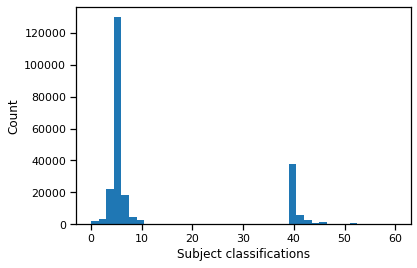

In [44]:
# plt.hist(by_galaxy['classification_id'], range=[0, 60], bins=40)
plt.hist(by_galaxy_new['smooth-or-featured_total-votes'], range=[0, 60], bins=40)
plt.xlabel('Subject classifications')
plt.ylabel('Count')

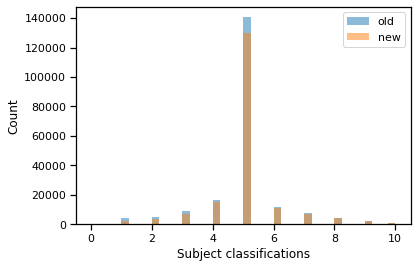

In [30]:
plt.hist(by_galaxy['classification_id'], range=[0, 10], bins=40, alpha=.5, label='old')
plt.hist(by_galaxy_new['smooth-or-featured_total-votes'], range=[0, 10], bins=40, alpha=.5, label='new')
plt.xlabel('Subject classifications')
plt.ylabel('Count')
plt.legend()

In [10]:
counts = by_galaxy['classification_id'].value_counts()

In [12]:
counts[counts.index < 10].sort_index()

1      4115
2      5096
3      9282
4     16571
5    140561
6     12010
7      7510
8      4133
9      1968
Name: classification_id, dtype: int64

In [13]:
by_classi = df.groupby('classification_id').agg({'subject_id': 'first', 'created_at': 'first'})


In [14]:
by_classi['created_at']

classification_id
97849522          2018-03-20T00:00:02.000Z
97849528          2018-03-20T00:00:03.000Z
97849533          2018-03-20T00:00:06.000Z
97849553          2018-03-20T00:00:14.000Z
97849579          2018-03-20T00:00:25.000Z
                         ...              
273046266    2020-09-11T10:45:53.000+01:00
273046304    2020-09-11T10:46:05.000+01:00
273046346    2020-09-11T10:46:20.000+01:00
273046353    2020-09-11T10:46:22.000+01:00
273046450    2020-09-11T10:46:53.000+01:00
Name: created_at, Length: 4408516, dtype: object

In [15]:
by_classi['created_at_dt'] = pd.to_datetime(by_classi['created_at'].apply(lambda x: x.split('T')[0]), infer_datetime_format=True)  # day resolution, for speed

In [16]:
still_classifying = by_classi[by_classi['created_at_dt'] > pd.to_datetime('2019-09-01')].reset_index()

In [17]:
still_classifying['created_at_dt']

0         2019-09-02
1         2019-09-02
2         2019-09-02
3         2019-09-02
4         2019-09-02
             ...    
1793754   2020-09-11
1793755   2020-09-11
1793756   2020-09-11
1793757   2020-09-11
1793758   2020-09-11
Name: created_at_dt, Length: 1793759, dtype: datetime64[ns]

In [18]:
still_classifying = still_classifying.groupby('subject_id').agg({'classification_id': lambda x: len(set(x))})

(array([7.32800e+03, 1.80540e+04, 2.89450e+04, 1.27902e+05, 1.92710e+04,
        4.33600e+03, 3.08300e+03, 5.17000e+02, 5.58000e+02, 2.05000e+02,
        3.28000e+02, 1.75000e+02, 3.37000e+02, 2.24000e+02, 5.17000e+02,
        3.37000e+02, 8.74000e+02, 5.98000e+02, 1.50600e+03, 9.30000e+02,
        1.99900e+03, 1.12600e+03, 2.34600e+03, 1.24000e+03, 2.46100e+03,
        1.27400e+03, 2.88300e+03, 1.25400e+03, 1.67900e+03, 5.52000e+02,
        5.12000e+02, 1.06000e+02, 8.10000e+01, 2.80000e+01, 2.20000e+01,
        1.20000e+01, 1.20000e+01, 9.00000e+00, 4.00000e+00, 5.00000e+00]),
 array([ 0. ,  1.5,  3. ,  4.5,  6. ,  7.5,  9. , 10.5, 12. , 13.5, 15. ,
        16.5, 18. , 19.5, 21. , 22.5, 24. , 25.5, 27. , 28.5, 30. , 31.5,
        33. , 34.5, 36. , 37.5, 39. , 40.5, 42. , 43.5, 45. , 46.5, 48. ,
        49.5, 51. , 52.5, 54. , 55.5, 57. , 58.5, 60. ]),
 <a list of 40 Patch objects>)

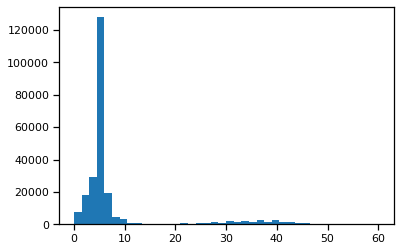

In [19]:
plt.hist(still_classifying['classification_id'], range=[0, 60], bins=40)

In [20]:
5 - still_classifying['classification_id'].values

array([4, 1, 3, ..., 3, 1, 2])

In [21]:
min_remaining_maybe_neg = 5 - still_classifying['classification_id'].values
min_remaining = np.max([min_remaining_maybe_neg, np.zeros_like(min_remaining_maybe_neg)], axis=0)
min_remaining

array([4, 1, 3, ..., 3, 1, 2])

In [22]:
min_remaining.sum()

122337

In [ ]:
# plus around 20k x 5 classifications for the missed galaxies I uploaded since then

In [12]:
# by_galaxy.query['classification_id'].value_counts()

In [13]:
# plt.hist(by_galaxy['classification_id'])

In [14]:
assert False

AssertionError: 

In [ ]:
df['question_response'] = df['question'] + '_' + df['response']

In [ ]:
by_user = pd.pivot_table(df, index=['user_id'], columns=['question_response'], values='response', aggfunc='count')
by_user = by_user.fillna(0)

In [ ]:
totals = pd.pivot_table(df, index=['user_id'], columns=['question'], values='response', aggfunc='count')
totals = totals.fillna(0)

In [ ]:
del df # save memory

In [ ]:
questions = list(totals.columns.values)
questions

In [ ]:
totals

In [ ]:
by_user

In [ ]:
by_user_totals = pd.merge(by_user, totals, how='inner', on='user_id')

In [ ]:
answers = []
for question in questions:
    for col in by_user_totals.columns.values:
        if col.startswith(question) and len(col) > len(question):
            answers.append(col)
            by_user_totals[col + '_fraction'] = by_user_totals[col] / by_user_totals[question]

In [ ]:
plt.hist(np.log10(by_user_totals['smooth-or-featured']), bins=40)

In [ ]:
by_user_totals['smooth-or-featured'].argmax()  # does not include not-logged-in

In [ ]:
# power_users = by_user_totals[by_user_totals['smooth-or-featured'] > 18]  # top 50% of users, 90% of classifications
power_users = by_user_totals[by_user_totals['smooth-or-featured'] > 47]  # top 25% of users, 80% of classifications
len(power_users)

In [ ]:
filled_questions = power_users.dropna(subset=questions)
len(filled_questions)

In [ ]:
_, bins = np.histogram(np.linspace(0, 1), bins=40)
filled_questions['smooth-or-featured_smooth_fraction'].hist(bins=bins)
mean_frac = filled_questions['smooth-or-featured_smooth'].sum() / filled_questions['smooth-or-featured'].sum()
plt.axvline(mean_frac, color='r')

In [ ]:
from scipy.stats import binom

In [ ]:
draws = 500
observed_fractions = []
for draw in range(draws):
    observed_fractions.append(binom(n=filled_questions['smooth-or-featured'].astype(int), p=mean_frac).rvs()/filled_questions['smooth-or-featured'])


In [ ]:
filled_questions['smooth-or-featured_smooth_fraction'].hist(bins=bins, density=True, alpha=.5, label='actual')
plt.hist(np.array(observed_fractions).flatten(), bins=bins, density=True, alpha=.5, label='binomial')
plt.xlabel('Mean "Smooth" Fraction of User')
plt.ylabel('Users (normalised)')
plt.legend()

In [ ]:
draws = 500
observed_fractions = []
for draw in range(draws):
    observed_fractions.append(binom(n=filled_questions['smooth-or-featured'].astype(int), p=filled_questions['smooth-or-featured_smooth_fraction']).rvs()/filled_questions['smooth-or-featured'])
plt.hist(np.array(observed_fractions).flatten(), bins=bins)

In [ ]:
filled_questions['smooth-or-featured_artifact_fraction'].hist(bins=40)
plt.axvline(filled_questions['smooth-or-featured_artifact'].sum() / filled_questions['smooth-or-featured'].sum(), color='r')

In [ ]:
filled_questions['has-spiral-arms_yes_fraction'].hist(bins=20)
plt.axvline(filled_questions['has-spiral-arms_yes'].sum() / filled_questions['has-spiral-arms'].sum(), color='r')

In [ ]:
filled_questions['bar_no_fraction'].hist(bins=20)
plt.axvline(filled_questions['bar_no'].sum() / filled_questions['bar'].sum(), color='r')

In [ ]:
# optionally rescale

In [ ]:
mapper = umap.UMAP().fit(filled_questions[questions])  # accidentally using the TOTAL votes, smooth-ish
umap.plot.points(mapper)

In [ ]:
key_questions = ['smooth-or-featured', 'bar', 'has-spiral-arms', 'spiral-count']
key_answers = [a for q in key_questions for a in answers if a.startswith(q) and not '_fraction' in a]
key_fractions = [a + '_fraction' for a in key_answers]
key_fractions

In [ ]:
# manual tweak to remove one answer from each q, because it provides no more information
key_answers_cut = key_answers[:2] + key_answers[3:5] + key_answers[6:7] + key_answers[8:10]
key_fractions_cut = key_fractions[:2] + key_fractions[3:5] + key_fractions[6:7] + key_fractions[8:10]
key_fractions_cut

In [ ]:
filled_answers = filled_questions.dropna(subset=key_fractions)
len(filled_answers)

In [ ]:
mapper = umap.UMAP().fit(filled_answers[key_fractions])
umap.plot.points(mapper)

In [ ]:
mapper = umap.UMAP().fit(filled_answers[key_fractions_cut])
umap.plot.points(mapper)

In [ ]:
# plt.scatter(
#     embedding[:, 0],
#     embedding[:, 1],
#     s=1,
#     c=filled_answers['smooth-or-featured']
# )
# #     c=[sns.color_palette()[x] for x in penguins.species_short.map({"Adelie":0, "Chinstrap":1, "Gentoo":2})])
# plt.gca().set_aspect('equal', 'datalim')
# plt.title('GZ volunteers by fraction', fontsize=24)

In [ ]:
mapper = umap.UMAP().fit(filled_answers[key_fractions])
outlier_scores = sklearn.neighbors.LocalOutlierFactor(contamination=0.05).fit_predict(filled_answers[key_fractions_cut])
umap.plot.points(mapper, labels=outlier_scores > 0)

In [ ]:
umap.plot.points(mapper, values=filled_answers['smooth-or-featured_artifact_fraction'])

In [ ]:
umap.plot.points(mapper, values=filled_answers['smooth-or-featured_smooth_fraction'])

In [ ]:
umap.plot.points(mapper, values=filled_answers['has-spiral-arms_yes_fraction'])

In [ ]:
umap.plot.points(mapper, values=filled_answers['bar_no_fraction'])

In [ ]:
filled_answers['total-votes-rank'] = np.argsort(filled_answers['smooth-or-featured'])

In [ ]:
umap.plot.points(mapper, values=filled_answers['total-votes-rank'])

In [ ]:
# mapper = umap.UMAP().fit(filled_answers[key_fractions_cut])
outlier_scores = sklearn.neighbors.LocalOutlierFactor(contamination=0.05).fit_predict(mapper.embedding_)
umap.plot.points(mapper, labels=outlier_scores > 0)

In [ ]:
# fit directly to the embedding
clusterer = hdbscan.HDBSCAN(min_cluster_size=20, min_samples=10, cluster_selection_epsilon=0.3).fit(mapper.embedding_)

In [ ]:
umap.plot.points(mapper, labels=clusterer.labels_)

In [ ]:
clusterer.labels_.max()

In [ ]:
value_counts = pd.value_counts(clusterer.labels_)
value_counts

In [ ]:
len(filled_answers)

In [ ]:
_, bins = np.histogram(np.linspace(0, 1), bins=20)
clusters = np.arange(np.max(clusterer.labels_))  # exclude -1, outliers
main_label = 1
remaining_label = 0

remaining = filled_answers[clusterer.labels_ == remaining_label]
fig, axes = plt.subplots(nrows=len(key_fractions_cut), figsize=(6, 14))
for ax_n, a in enumerate(key_fractions_cut):
    ax = axes[ax_n]
    for cluster in clusters:
        sample = filled_answers[clusterer.labels_ == cluster]
        try:
            sns.kdeplot(sample[a], label=cluster, alpha=.5, ax=ax)
        except:
            ax.plot(np.linspace(0, 1), np.zeros(50), label=cluster)  # just to keep the colors cycling correctly
    #     ax.hist(remaining[a], bins=bins, label='remaining', density=True, alpha=.5)
    ax.legend()
    ax.set_xlim([0., 1.])
    ax.set_xlabel(a)
fig.tight_layout()

In [ ]:
clusterer.condensed_tree_.plot(select_clusters=True)

In [ ]:
sns.distplot(clusterer.outlier_scores_[np.isfinite(clusterer.outlier_scores_)], rug=True)

In [ ]:
clusterer = hdbscan.HDBSCAN().fit(filled_answers[key_fractions])
pd.value_counts(clusterer.labels_)

In [ ]:
clusterer.condensed_tree_.plot(select_clusters=True)

In [ ]:
umap.plot.points(mapper, labels=clusterer.labels_)

In [ ]:
umap.plot.points(mapper, labels=clusterer.labels_ == 0)

In [ ]:
umap.plot.points(mapper, labels=clusterer.labels_ == -1)

In [ ]:
sns.distplot(clusterer.outlier_scores_[np.isfinite(clusterer.outlier_scores_)], rug=True)

In [ ]:
# plt.scatter(
#     mapper.embedding_[:, 0],
#     mapper.embedding_[:, 1],
#     c=clusterer.outlier_scores_ < 0.1,
#     s=1.
# )
# plt.gca().set_aspect('equal', 'datalim')
# plt.title('UMAP projection of the Penguin dataset', fontsize=24)


In [ ]:
_, bins = np.histogram(np.linspace(0, 1), bins=20)
main_sample = filled_answers[clusterer.labels_ == 6]
remaining = filled_answers[clusterer.labels_ != 6]
fig, axes = plt.subplots(nrows=len(key_fractions_cut), figsize=(6, 14))
for ax_n, a in enumerate(key_fractions_cut):
    ax = axes[ax_n]
    ax.hist(main_sample[a], bins=bins, label='main', density=True, alpha=.5)
    ax.hist(remaining[a], bins=bins, label='remaining', density=True, alpha=.5)
    ax.legend()
    ax.set_xlabel(a)
fig.tight_layout()

In [ ]:
main_sample['smooth-or-featured_smooth'].sum(), remaining['smooth-or-featured_smooth'].sum()

In [ ]:
key_fractions_cut

In [ ]:
renamer = {
    'smooth-or-featured_artifact_fraction': 'artifact_',
     'smooth-or-featured_featured-or-disk_fraction': 'featured_',
     'bar_no_fraction': 'bar_no_',
     'bar_strong_fraction': 'bar_strong_',
     'has-spiral-arms_no_fraction': 'spiral_no_',
     'spiral-winding_loose_fraction': 'spiral_loose_',
     'spiral-winding_medium_fraction': 'winding_med_'
}

In [ ]:
to_plot = filled_answers.copy()
to_plot = to_plot.rename(columns=renamer)
to_plot[renamer.values()]

In [ ]:
to_plot['bar_no_']

In [ ]:
to_plot.query('hdbscan_main_cluster')['artifact_'].mean()

In [ ]:
to_plot.query('not hdbscan_main_cluster')['artifact_'].mean()

In [ ]:
to_plot['hdbscan_cluster'] = clusterer.labels_
to_plot['hdbscan_main_cluster'] = clusterer.labels_ == 1
sns.pairplot(to_plot, vars=list(renamer.values()), hue='hdbscan_main_cluster', kind='kde')

In [ ]:
to_plot['artifact_']

In [ ]:
to_plot['featured_']